# Lorentz 96: EnKF & localisation

In [52]:
import numpy as np
import math
import scipy as scp
import scipy.sparse as scps
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#-------------------------------------------------------
# Lorenz 96
#-------------------------------------------------------
N = 40 # Nombre de points sur l'anneau

class Model:
    def __init__(self, nmembers = 1):
        self.nmembers = nmembers
        self.nx = N    # Nombre de points
        self.F = 8     # Forçage externe
        self.dt = 0.01
        self.x0 = np.ones(self.nx)*self.F
        self.x0[0] += 0.01
        self.xvar = self.initial_condition()
        self.xvar_series = []
        self.time = 0.
        self.time_series = []
    
    def initial_condition(self, sigma=1.):
        if self.nmembers == 1:
            xout = self.x0.reshape((self.nx, 1)).copy()
        else:
            p0 = sigma*np.eye(self.nx)
            xout = np.random.multivariate_normal(self.x0, p0, self.nmembers).T
        return xout
    
    def rhs(self,x_in):
        """Second membre"""
        x_out = (np.roll(x_in, -1, axis=0) - np.roll(x_in, 2, axis=0)) * np.roll(x_in, 1, axis=0) - x_in + self.F
        return x_out
    
    def forward(self, nstep_in):
        """Intégration temporelle"""
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            self.xvar_series[:,it,:] = self.xvar
            self.time_series[it] = self.time
            k1=self.rhs(self.xvar)*self.dt
            xtmp=self.xvar+0.5*k1
            k2=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+0.5*k2
            k3=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+k2
            k4=self.rhs(xtmp)*self.dt
            self.xvar+=(k1+2*k2+2*k3+k4)/6.
            self.time += self.dt
    
    def plot(self, ncomp = 4):
        """Affichage"""
        plt.figure(figsize=(12,8))
        ncomp = min(ncomp,self.nx)
        for ix in range(ncomp):
            plt.subplot(ncomp,1,ix+1)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.show()

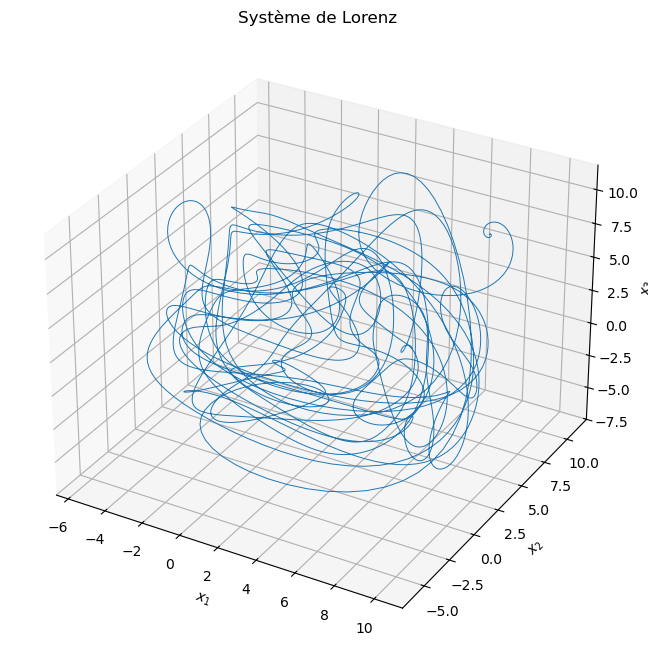

In [54]:
# Illustration du système de Lorenz 96 #
lorenz_test = Model()
lorenz_test.forward(3000)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[1,:,0], lorenz_test.xvar_series[2,:,0], lw=0.7)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
ax.set_title("Système de Lorenz")
plt.show()

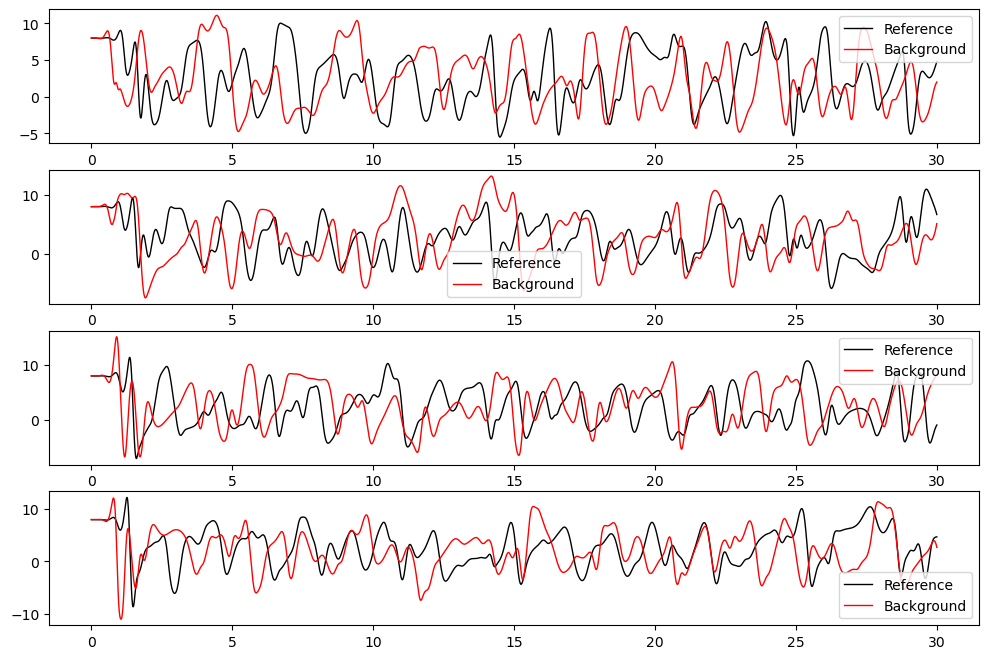

In [ ]:
# Simulation de référence
ntime=3000
lorenz_ref = Model()
lorenz_ref.forward(ntime)
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

# Simulation de l'ébauche
# TODO: échelles d'erreur F/x0/sigma pour chaque membre/perturbation à ajuster
lorenz_bkg = Model()
lorenz_bkg.F = lorenz_ref.F + 0.1 # Erreur sur le paramètre F
lorenz_bkg.x0 = np.ones(lorenz_bkg.nx)*lorenz_ref.F + np.random.normal(0,0.01,lorenz_bkg.nx) # Erreur sur la condition initiale
lorenz_bkg.x0[0] += 0.01
lorenz_bkg.xvar = lorenz_bkg.initial_condition()
lorenz_bkg.forward(ntime)

plt.figure(figsize=(12,8))
ncomp = 4
for ix in range(ncomp):
    plt.subplot(ncomp,1,ix+1)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_bkg.time_series,lorenz_bkg.xvar_series[ix,:,0],'red',linewidth=1.,label='Background')
    plt.legend()
plt.show()

In [89]:
# Configuration des observations
nobs = 20
nvarobs = np.random.choice(range(N), nobs, replace=False)
nvarobs.sort()
H=np.zeros((nobs,N)) # Opérateur d'observation
for iobs in range(nobs):
    H[iobs,nvarobs[iobs]]=1.
assim_steps = range(25,ntime,50) # Temps d'assimilation
nassim = len(assim_steps)
lencycle = np.hstack((assim_steps[0], np.ediff1d(assim_steps)))
so2=9.e-2
Robs = so2*np.eye(nobs) # Matrice de covariance

In [129]:
# Analyse par EnKF ou ETKF #
def analysis(Ef,y,Robs,H,methode,moderation):
    # Paramètres d'entrée :
    # Ef : ensemble de prévision
    # y : vecteur d'observations
    # Robs : matrice de covariance d'erreur d'observation
    # H : operateur d'observation
    # methode : 1 ETKF, sinon EnKF
    # moderation : paramètres de modération : inflation pour gonfler et localisation
    #################################
    # Sortie : 
    # Ea : ensemble d'analyse
    n = Ef.shape[1]
    e = np.ones((n, 1))

    xf = Ef @ e / n  # moyenne d'état de l'ensemble de prévision
    Af = Ef - xf @ e.T

    inv_sqrtR = np.linalg.inv(scp.linalg.sqrtm(Robs))
    S = inv_sqrtR @ H @ Af / math.sqrt(n - 1)
    mid = np.eye(nobs) + S @ S.T
    mid_inv = np.linalg.solve(mid, np.eye(nobs))
    G = S.T @ mid_inv

    xa = xf + Af @ G @ inv_sqrtR @ (y - H @ xf) / math.sqrt(n - 1)
    if methode == 1:
        mid2 = np.eye(n) + S.T @ S
        eigval, eigvec = np.linalg.eigh(mid2)
        # eigval = np.clip(eigval, 1e-9, None)
        T = eigvec @ (np.diag(1.0 / np.sqrt(eigval))) @ eigvec.T
        T = T - np.eye(n)
    else:
        Dtilde = np.random.multivariate_normal(np.zeros(nobs), Robs, n).T
        D = inv_sqrtR @ Dtilde / math.sqrt(n - 1)
        T = G @ (D - S)
    Aa = Af + Af @ T
    Ea = xa @ e.T + Aa

    return Ea

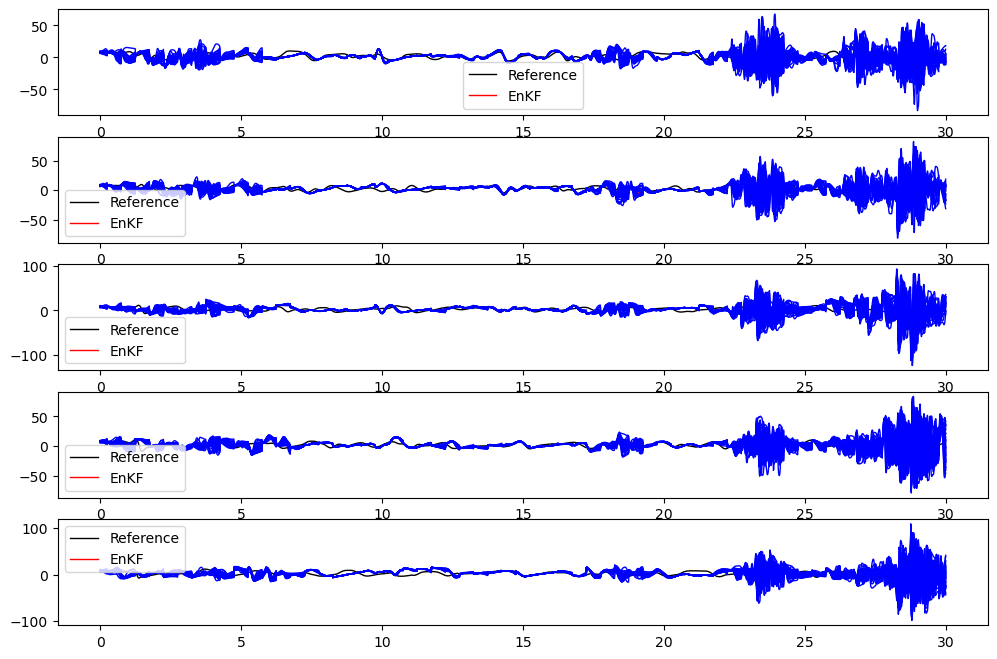

In [130]:
#Cycle d'assimilation par filtres de Kalman d'ensemble
methode=0 # 0 pourEnKF, 1 pour ETKF
nmem=30
lorenz_assim = Model(nmembers=nmem)
lorenz_assim.x0 = lorenz_bkg.x0
lorenz_assim.F = lorenz_bkg.F
lorenz_assim.xvar = lorenz_assim.initial_condition()
do_assim=1

time1 = np.empty(ntime)
xvar1 = np.empty((lorenz_assim.nx, ntime, nmem))

for ic in range(nassim):
    ## Forecast
    if ic == 0:
        nstep = assim_steps[0]
    else:
        nstep = assim_steps[ic] - assim_steps[ic-1]
        
    lorenz_assim.forward(nstep)
    
    if ic == 0:
        time1 = lorenz_assim.time_series
        xvar1 = lorenz_assim.xvar_series
    else:
        time1 = np.hstack(( time1, lorenz_assim.time_series ))
        xvar1 = np.concatenate( ( xvar1, lorenz_assim.xvar_series ), axis = 1 )
    
    ## Analysis
    obs_index = np.argwhere( true_time == lorenz_assim.time )
    y=np.transpose(true_state[nvarobs, obs_index, 0] +np.dot(math.sqrt(so2)*np.eye(nobs),np.random.normal(0,1,(nobs,))))
    if(do_assim==1):
        lorenz_assim.xvar = analysis(lorenz_assim.xvar,y,Robs,H,methode,[])

## Last cycle
lorenz_assim.forward( ntime - assim_steps[-1] )
time1 = np.hstack(( time1, lorenz_assim.time_series ))
xvar1 = np.concatenate( ( xvar1, lorenz_assim.xvar_series ), axis = 1 )

## Plots
xvarmean = np.mean(xvar1, axis=2)

plt.figure(figsize=(12,8))
ncomp = 5
for ix in range(ncomp):
    plt.subplot(ncomp,1,ix+1)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(time1, xvarmean[ix,:],'red',linewidth=1.,label='EnKF')
    plt.legend()
    for ie in range(nmem):
        plt.plot(time1, xvar1[ix,:, ie],'blue',linewidth=1.)
plt.show()